## 기본모델 결과

🛠️ 모델과 데이터를 불러오는 중...
✅ 가중치 로드 완료: ./runs/rsna_clf_efficientnet/best_efficientnet_fold1.pth


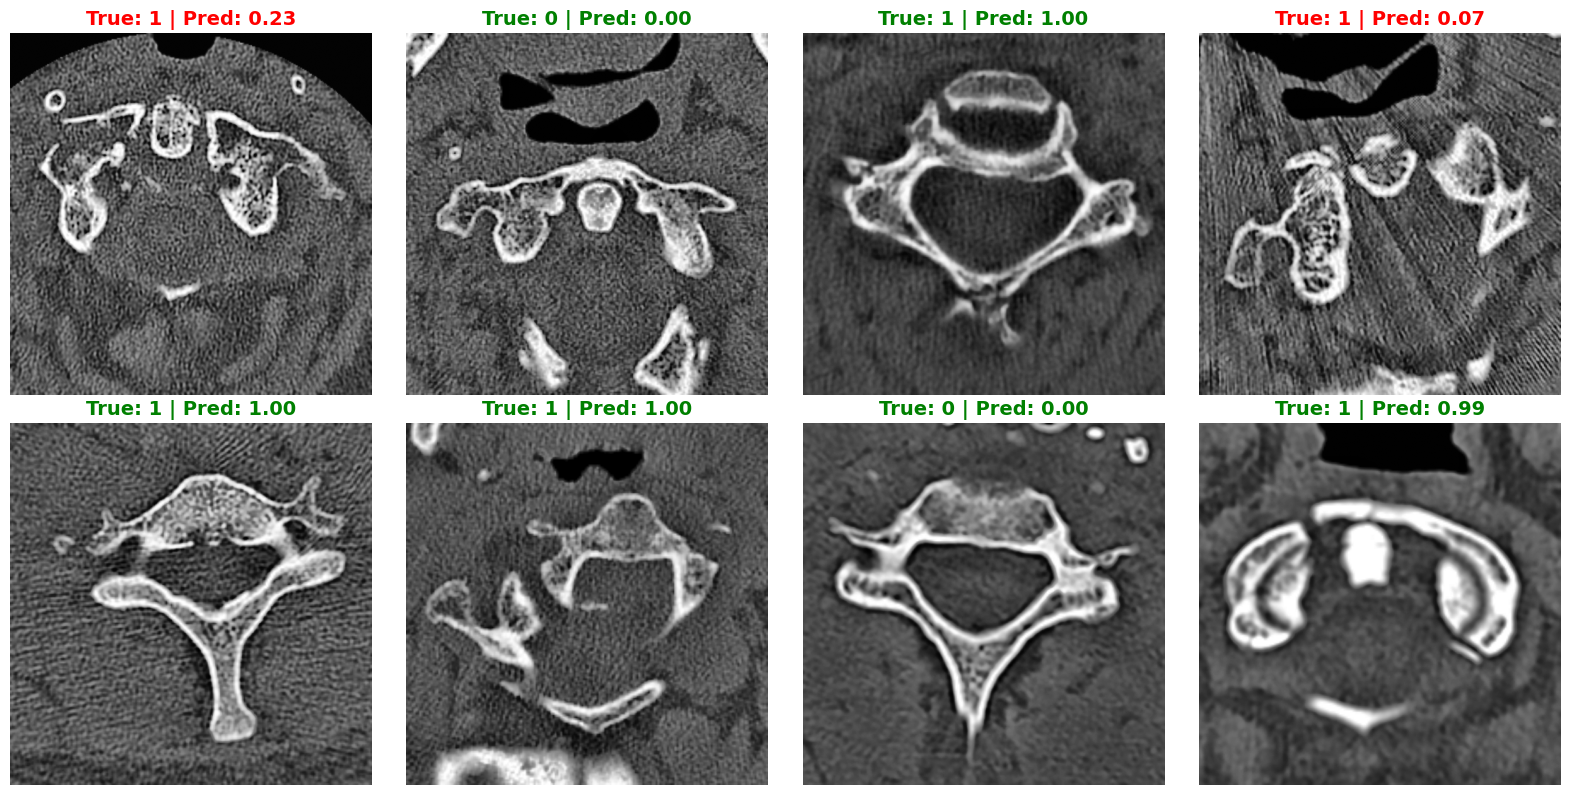

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import cv2
import timm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import random

# --- [1. 설정 (경로 확인 필수!)] ---
CONFIG = {
    'base_dir': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset',
    'manifest_path': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\det_train_manifest_balanced_1to1.csv',
    
    'model_name': 'tf_efficientnetv2_s.in21k_ft_in1k', 
    'img_size': 512,
    
    # 🎯 [중요] 방금 학습을 멈추고 저장된 .pth 파일의 경로를 적어주세요!
    'weights_path': './runs/rsna_clf_efficientnet/best_efficientnet_fold1.pth', 
    
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_samples': 8 # 눈으로 확인할 이미지 개수 (8장)
}

# --- [2. 검증용 전처리] ---
val_transforms = A.Compose([
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# --- [3. 데이터셋 클래스 (시각화를 위해 원본 이미지도 반환하도록 살짝 수정)] ---
class RSNATestDataset(Dataset):
    def __init__(self, df, base_dir, transforms=None):
        self.df = df
        self.base_dir = base_dir
        self.transforms = transforms
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        full_path = os.path.join(self.base_dir, row['file_path'])
        
        try:
            with np.load(full_path) as loaded:
                img = loaded['data'].astype(np.float32) 
        except:
            img = np.zeros((3, 512, 512), dtype=np.float32)

        img_uint8 = (img * 255).astype(np.uint8)
        channels = []
        for i in range(3):
            channels.append(self.clahe.apply(img_uint8[i]))
        
        img_hwc = np.stack(channels, axis=-1) 
        
        # 모델에 들어갈 텐서 (정규화 됨)
        if self.transforms:
            augmented = self.transforms(image=img_hwc)
            img_tensor = augmented['image']
        else:
            img_tensor = torch.from_numpy(np.transpose(img_hwc, (2,0,1))).float() / 255.0

        label = float(row['fracture'])
        
        # 시각화를 위해 가운데(현재) 슬라이스 원본을 같이 넘겨줍니다.
        vis_img = channels[1] # 3채널 중 가운데 채널(Index 1) 추출
        
        return img_tensor, label, vis_img

# --- [4. 모델 로드 및 추론 시각화 실행] ---
def visualize_predictions():
    print("🛠️ 모델과 데이터를 불러오는 중...")
    
    # 1. 데이터 로드 (Fold 1 검증 데이터에서만 뽑음)
    df = pd.read_csv(CONFIG['manifest_path'])
    val_df = df[df['fold'] == 1].reset_index(drop=True)
    
    # 무작위로 8장 뽑기
    sample_df = val_df.sample(n=CONFIG['num_samples'], random_state=random.randint(0, 10000))
    test_ds = RSNATestDataset(sample_df, CONFIG['base_dir'], transforms=val_transforms)
    test_loader = DataLoader(test_ds, batch_size=CONFIG['num_samples'], shuffle=False)
    
    # 2. 모델 로드
    model = timm.create_model(CONFIG['model_name'], pretrained=False, in_chans=3, num_classes=1)
    
    if os.path.exists(CONFIG['weights_path']):
        model.load_state_dict(torch.load(CONFIG['weights_path'], map_location=CONFIG['device']))
        print(f"✅ 가중치 로드 완료: {CONFIG['weights_path']}")
    else:
        print(f"❌ 가중치 파일이 없습니다! 경로를 확인하세요: {CONFIG['weights_path']}")
        return
        
    model.to(CONFIG['device'])
    model.eval()
    
    # 3. 추론 진행
    with torch.no_grad():
        for images, labels, vis_imgs in test_loader:
            images = images.to(CONFIG['device'])
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            labels = labels.numpy()
            break # 한 배치(8장)만 처리하고 나옴
            
    # 4. 결과 시각화
    plt.figure(figsize=(16, 8))
    for i in range(CONFIG['num_samples']):
        plt.subplot(2, 4, i+1)
        
        # 흑백 이미지 출력
        plt.imshow(vis_imgs[i], cmap='gray')
        plt.axis('off')
        
        # 정답 및 예측 확률 텍스트 생성
        true_lbl = int(labels[i])
        pred_prob = probs[i]
        pred_lbl = 1 if pred_prob >= 0.5 else 0
        
        # 맞췄으면 초록색, 틀렸으면 빨간색으로 표시
        color = 'green' if true_lbl == pred_lbl else 'red'
        
        title_text = f"True: {true_lbl} | Pred: {pred_prob:.2f}"
        plt.title(title_text, color=color, fontsize=14, fontweight='bold')
        
    plt.tight_layout()
    plt.show()

# 실행!
if __name__ == '__main__':
    visualize_predictions()

## 과적합 방지

🛠️ 모델과 데이터를 불러오는 중... (Threshold: 0.1)
✅ 가중치 로드 완료: ./runs/rsna_clf_efficientnet2/best_efficientnet_fold1.pth


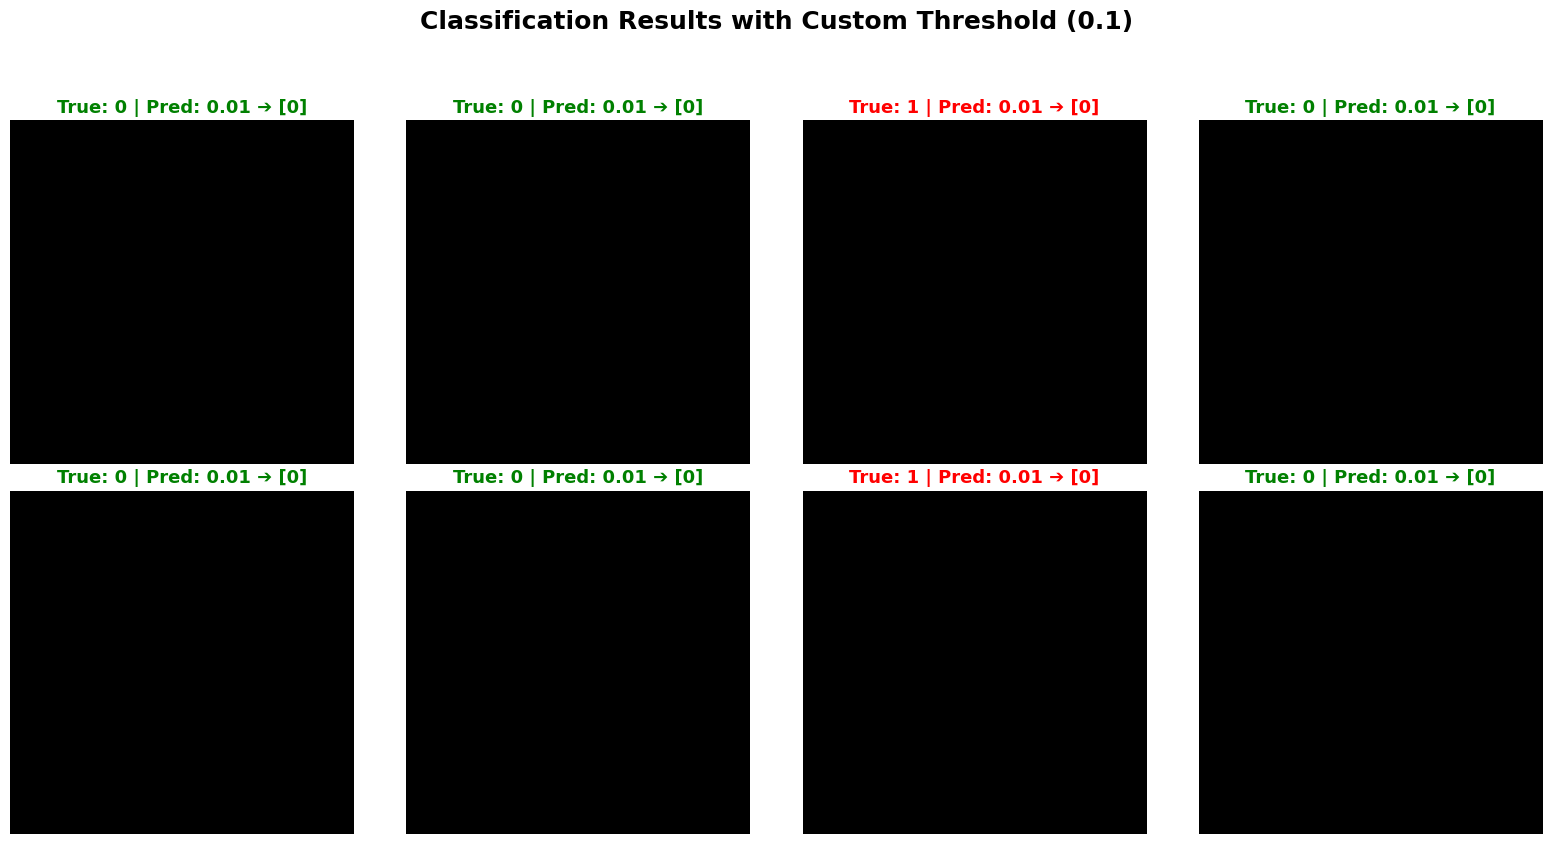

In [38]:
import os
import torch
import pandas as pd
import numpy as np
import cv2
import timm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import random

# --- [1. 설정 (경로 확인 필수!)] ---
CONFIG = {
    'base_dir': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset',
    'manifest_path': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\det_train_manifest_balanced_1to1.csv',
    
    'model_name': 'tf_efficientnetv2_s.in21k_ft_in1k', 
    'img_size': 512,
    
    # 🎯 [중요] 방금 학습을 멈추고 저장된 .pth 파일의 경로를 적어주세요!
    'weights_path': './runs/rsna_clf_efficientnet2/best_efficientnet_fold1.pth', 
    
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_samples': 8, # 눈으로 확인할 이미지 개수 (8장)
    
    # 🔥 [추가] 우리가 선택한 새로운 임계값 설정
    'threshold': 0.1 
}

# --- [2. 검증용 전처리] ---
val_transforms = A.Compose([
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# --- [3. 데이터셋 클래스] ---
class RSNATestDataset(Dataset):
    def __init__(self, df, base_dir, transforms=None):
        self.df = df
        self.base_dir = base_dir
        self.transforms = transforms
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        full_path = os.path.join(self.base_dir, row['file_path'])
        
        try:
            with np.load(full_path) as loaded:
                img = loaded['data'].astype(np.float32) 
        except:
            img = np.zeros((3, 512, 512), dtype=np.float32)

        img_uint8 = (img * 255).astype(np.uint8)
        channels = []
        for i in range(3):
            channels.append(self.clahe.apply(img_uint8[i]))
        
        img_hwc = np.stack(channels, axis=-1) 
        
        if self.transforms:
            augmented = self.transforms(image=img_hwc)
            img_tensor = augmented['image']
        else:
            img_tensor = torch.from_numpy(np.transpose(img_hwc, (2,0,1))).float() / 255.0

        label = float(row['fracture'])
        vis_img = channels[1] 
        
        return img_tensor, label, vis_img

# --- [4. 모델 로드 및 추론 시각화 실행] ---
def visualize_predictions():
    print(f"🛠️ 모델과 데이터를 불러오는 중... (Threshold: {CONFIG['threshold']})")
    
    df = pd.read_csv(CONFIG['manifest_path'])
    val_df = df[df['fold'] == 1].reset_index(drop=True)
    
    sample_df = val_df.sample(n=CONFIG['num_samples'], random_state=random.randint(0, 10000))
    test_ds = RSNATestDataset(sample_df, CONFIG['base_dir'], transforms=val_transforms)
    test_loader = DataLoader(test_ds, batch_size=CONFIG['num_samples'], shuffle=False)
    
    model = timm.create_model(CONFIG['model_name'], pretrained=False, in_chans=3, num_classes=1)
    
    if os.path.exists(CONFIG['weights_path']):
        model.load_state_dict(torch.load(CONFIG['weights_path'], map_location=CONFIG['device']))
        print(f"✅ 가중치 로드 완료: {CONFIG['weights_path']}")
    else:
        print(f"❌ 가중치 파일이 없습니다! 경로를 확인하세요: {CONFIG['weights_path']}")
        return
        
    model.to(CONFIG['device'])
    model.eval()
    
    with torch.no_grad():
        for images, labels, vis_imgs in test_loader:
            images = images.to(CONFIG['device'])
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            labels = labels.numpy()
            break 
            
    # --- 🎨 시각화 ---
    plt.figure(figsize=(16, 8))
    # 제목에 임계값 명시
    plt.suptitle(f"Classification Results with Custom Threshold ({CONFIG['threshold']})", fontsize=18, fontweight='bold', y=1.05)
    
    for i in range(CONFIG['num_samples']):
        plt.subplot(2, 4, i+1)
        
        plt.imshow(vis_imgs[i], cmap='gray')
        plt.axis('off')
        
        true_lbl = int(labels[i])
        pred_prob = probs[i]
        
        # 🔥 [핵심 수정] 0.5가 아닌 0.1(CONFIG 설정값)을 기준으로 판별!
        pred_lbl = 1 if pred_prob >= CONFIG['threshold'] else 0
        
        # 맞췄으면 초록색, 틀렸으면 빨간색
        color = 'green' if true_lbl == pred_lbl else 'red'
        
        title_text = f"True: {true_lbl} | Pred: {pred_prob:.2f} ➔ [{pred_lbl}]"
        plt.title(title_text, color=color, fontsize=13, fontweight='bold')
        
    plt.tight_layout()
    plt.show()

# 실행!
if __name__ == '__main__':
    visualize_predictions()